In [3]:
from keras.models import Sequential
import numpy as np
from six.moves import range
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import matplotlib.pyplot as plt
from keras import metrics
import json

# Parameters Config

In [362]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [363]:
TRAINING_SIZE = 80000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [364]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [365]:
ctable = CharacterTable(chars)

In [366]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [367]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 80000


In [368]:
print(questions[:5], expected[:5])

['0+706  ', '9+2    ', '75+7   ', '3+474  ', '7+5    '] ['706 ', '11  ', '82  ', '477 ', '12  ']


# Processing

In [369]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [370]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:20000]
train_y = y[:20000]
test_x = x[20000:]
test_y = y[20000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Validation Data:
(2000, 7, 12)
(2000, 4, 12)
Testing Data:
(60000, 7, 12)
(60000, 4, 12)


In [371]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False  True False False False False False False False
   False]
  [False False False False False False False False False False  True
   False]
  [False False False False False False False False False  True False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False False False False False  True False False False False False
   False]
  [False False False False False  True False False False False False
   False]]

 [[False False False False  True False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False False  True False
   False]
  [False False False False False False False False False  True False
   False]
  [False False False False False  True Fal

# Build Model

In [372]:
from keras import metrics
print('Build model...')

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(100, input_shape=(MAXLEN, len(chars))))
model.add(RepeatVector(DIGITS+1))
model.add(RNN(80, return_sequences=True))
model.add(TimeDistributed(Dense(12, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 100)               45200     
_________________________________________________________________
repeat_vector_33 (RepeatVect (None, 4, 100)            0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 4, 80)             57920     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 4, 12)             972       
Total params: 104,092
Trainable params: 104,092
Non-trainable params: 0
_________________________________________________________________


# Training

In [373]:
print()
print('-' * 50)
#print('Iteration', iteration)
result = model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=100,
            validation_data=(x_val, y_val))
def print_result():    
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Train on 18000 samples, validate on 2000 samples
Epoch 1/100
18000/18000 [==============================] - 9s 488us/step - loss: 2.0540 - acc: 0.2785 - val_loss: 1.8764 - val_acc: 0.3230
Epoch 2/100
18000/18000 [==============================] - 4s 232us/step - loss: 1.8624 - acc: 0.3289 - val_loss: 1.8636 - val_acc: 0.3301
Epoch 3/100
18000/18000 [==============================] - 4s 238us/step - loss: 1.8311 - acc: 0.3331 - val_loss: 1.8134 - val_acc: 0.3289
Epoch 4/100
18000/18000 [==============================] - 4s 196us/step - loss: 1.8030 - acc: 0.3352 - val_loss: 1.7884 - val_acc: 0.3336 1.8049 - acc:
Epoch 5/100
18000/18000 [==============================] - 3s 192us/step - loss: 1.7783 - acc: 0.3429 - val_loss: 1.7653 - val_acc: 0.3428
Epoch 6/100
18000/18000 [==============================] - 3s 181us/step - loss: 1.7396 - acc: 0.3522 - val_loss: 1.7138 - val_acc: 0.3536
Epoch 7/100
18000/18000 [==========================

# Testing

In [376]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
accur = 0 
for i in range(len(test_x)):
    ind = i
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if i % 1000 == 0:
        print(i)
    if correct == guess:
        accur += 1
accur = accur / len(test_x)
print("Accuracy: ",accur)

MSG : Prediction
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
Accuracy:  0.9399166666666666


In [377]:
fp = open("Accuracy(add,training_size = 18000).txt", "a")
fp.write(str(accur)+'\n')
fp.close()

# Analysis of Different Digits and Different Training Data Size
### 1.Training data size = 18000
### 2.Validation data size = 2000
### 3.Test data size = 60000

In [54]:
alll_18000 = {}
for i in range(3,6):
    with open('DIGIT-'+str(i)+'(add,training_size = 18000).json','r') as f:
        result = json.load(f)
    alll_18000[str(i)] = result

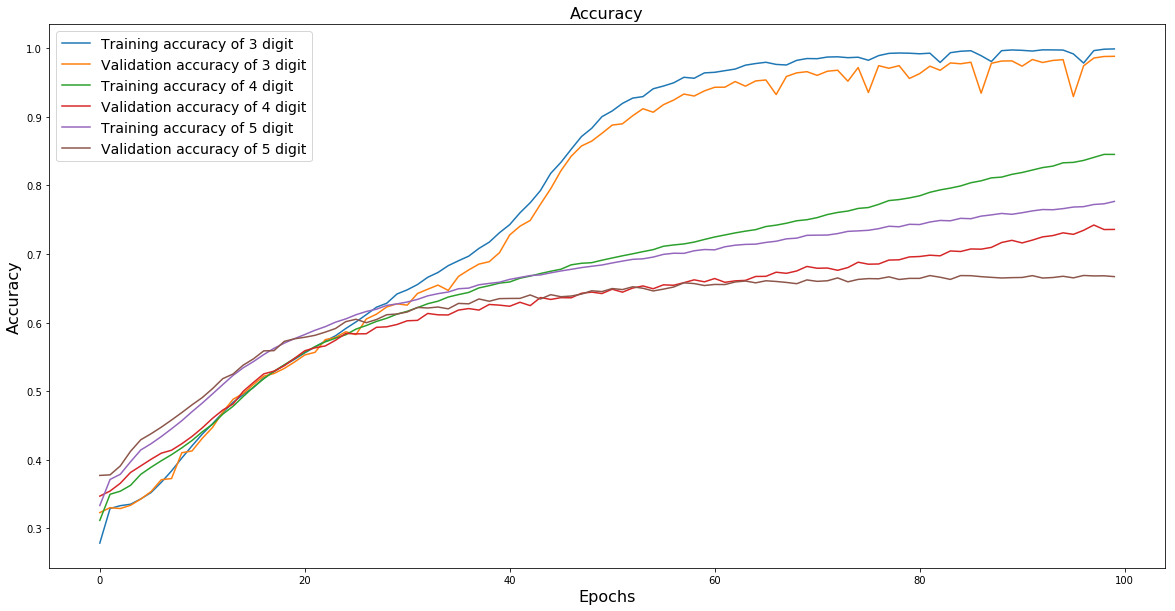

In [55]:
plt.figure(figsize=(20,10))
for i in range(3,6):
    acc = alll_18000[str(i)]['acc']
    val_acc = alll_18000[str(i)]['val_acc']
    plt.plot(acc, label='Training accuracy of %i digit' %i)
    plt.plot(val_acc, label='Validation accuracy of %i digit' %i)
plt.title('Accuracy',fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [56]:
Accuracy_data = open('Accuracy(add,training_size = 18000).txt','r')
io = Accuracy_data.readlines()
print("Test accuracy of 3 digit is ",io[0][:-1])
print("Test accuracy of 4 digit is ",io[1][:-1])
print("Test accuracy of 5 digit is ",io[2][:-1])

Test accuracy of 3 digit is  0.9399166666666666
Test accuracy of 4 digit is  0.23208333333333334
Test accuracy of 5 digit is  0.0808


## Conclusion
- 從上圖可以得知，隨著 digit 增加，validation accuracy 會下降。
- 在 digit 為 4、5 的情況下有 overfitting 的情況發生

## 1.Training data size = 36000
## 2.Validation data size = 4000
## 3.Test data size = 40000

In [58]:
alll_36000 = {}
for i in range(3,6):
    with open('DIGIT-'+str(i)+'(add,training_size = 36000).json','r') as f:
        result = json.load(f)
    alll_36000[str(i)] = result

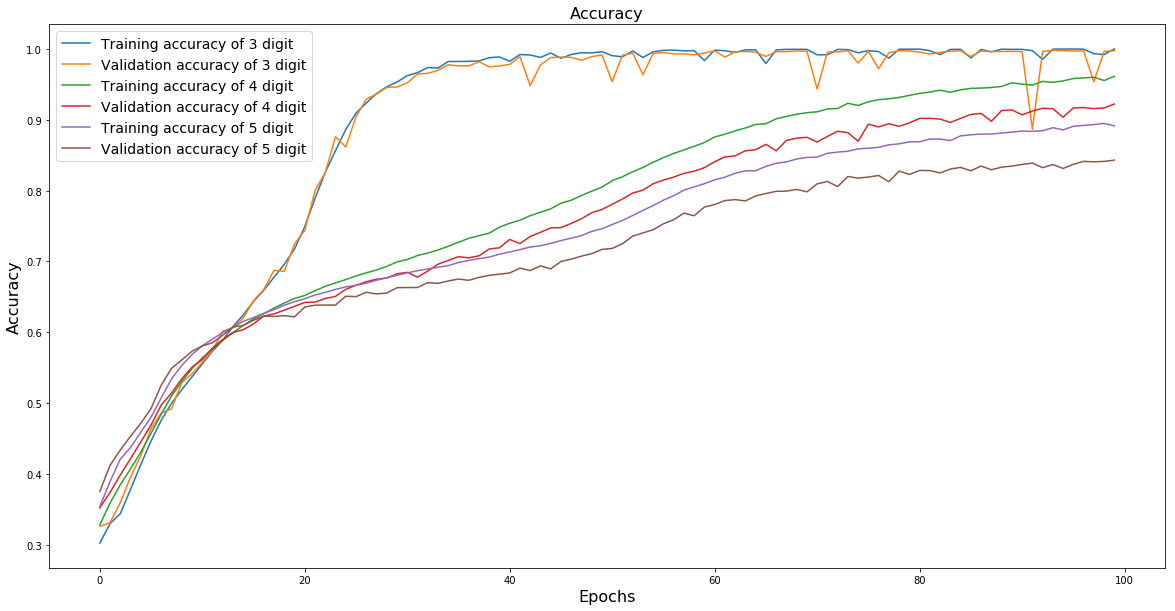

In [59]:
plt.figure(figsize=(20,10))
for i in range(3,6):
    acc = alll_36000[str(i)]['acc']
    val_acc = alll_36000[str(i)]['val_acc']
    plt.plot(acc, label='Training accuracy of %i digit' %i)
    plt.plot(val_acc, label='Validation accuracy of %i digit' %i)
plt.title('Accuracy',fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=14)
plt.show()

In [60]:
Accuracy_data = open('Accuracy(add,training_size = 36000).txt','r')
io = Accuracy_data.readlines()
print("Test accuracy of 3 digit is ",io[0][:-1])
print("Test accuracy of 4 digit is ",io[1][:-1])
print("Test accuracy of 5 digit is ",io[2][:-1])

Test accuracy of 3 digit is  0.987925
Test accuracy of 4 digit is  0.712375
Test accuracy of 5 digit is  0.443475


## Conclusion
- 從上圖可以得知，隨著 training data size 增加的情況下，validation accuracy 也上升許多。